# Using Pyro 
## Bayesian Regression - Introduction (Part 1)

Following the tutorial [here](http://pyro.ai/examples/bayesian_regression.html#)

Want to explore the relationship between the ruggedness of terrain and a counrties GDP. 

In [3]:
import os
from functools import partial
import torch 
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib as plt

import pyro 
import pyro.distributions as dist 

# for CI testing 
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(1)

# Set matplotlib settings 
%matplotlib inline 
plt.style.use('default')


In [5]:
# Dataset 

# rugged - quantifies the Terrain ruggedness Index 
# cont_africa - whether the given nation is in Africa 
# rgdppc_2000 - real GDP per capita for the year 2000

DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Terrain ruggedness index'),
 Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 1.0, 'African nations')]

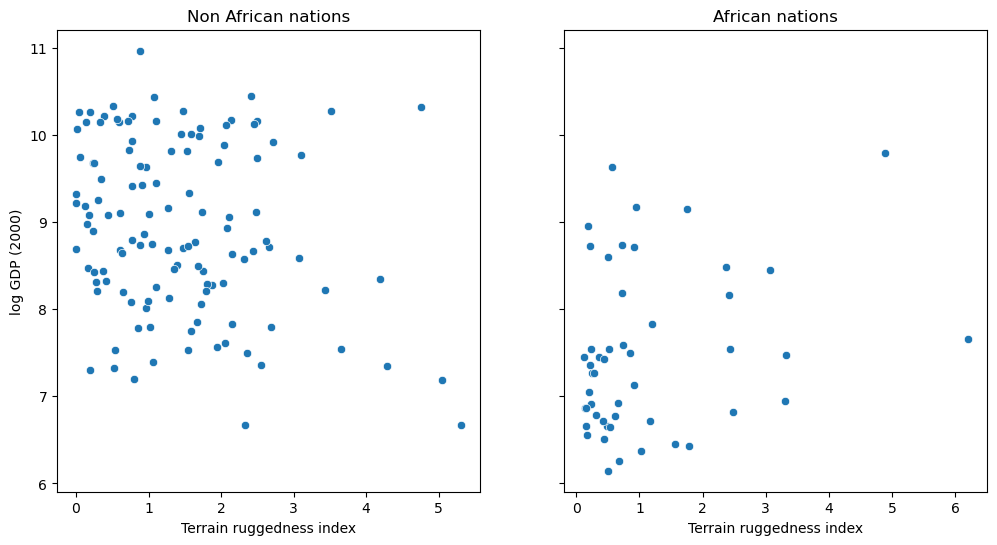

In [7]:
fig, ax = plt.pyplot.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]

sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel='Terrain ruggedness index', 
          ylabel="log GDP (2000)", 
          title="Non African nations")

sns.scatterplot(african_nations["rugged"],
            african_nations["rgdppc_2000"],
            ax=ax[1])
ax[1].set(xlabel='Terrain ruggedness index', 
          ylabel="log GDP (2000)", 
          title="African nations")

In [8]:
# Linear regression 
# Want to predict log GDP as a function of whether the country is in Africa, and it's terrain ruggedness

from torch import nn 
from pyro.nn import PyroModule

In [17]:
# Training with PyTorch Optimisers

# add a feature to capture te interaction between 'cont_africa' and 'rugged' 
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# regression model 
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize 
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2 

def train(): 
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss 
    loss =  loss_fn(y_pred, y_data)
    # initialise the gradients to zero 
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step 
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1)%50 == 0: 
        print("[iteration %04d] loss: %.4f" % (j+1, loss.item()))

# Inspect the learned parameters 
print('Learned parameters:')
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())


[iteration 0050] loss: 3072.1045
[iteration 0100] loss: 1584.3365
[iteration 0150] loss: 1079.0814
[iteration 0200] loss: 798.0782
[iteration 0250] loss: 600.8732
[iteration 0300] loss: 453.6887
[iteration 0350] loss: 346.5816
[iteration 0400] loss: 272.0951
[iteration 0450] loss: 222.6225
[iteration 0500] loss: 191.1840
[iteration 0550] loss: 172.0413
[iteration 0600] loss: 160.8624
[iteration 0650] loss: 154.5973
[iteration 0700] loss: 151.2263
[iteration 0750] loss: 149.4848
[iteration 0800] loss: 148.6208
[iteration 0850] loss: 148.2093
[iteration 0900] loss: 148.0212
[iteration 0950] loss: 147.9387
[iteration 1000] loss: 147.9040
[iteration 1050] loss: 147.8900
[iteration 1100] loss: 147.8846
[iteration 1150] loss: 147.8826
[iteration 1200] loss: 147.8819
[iteration 1250] loss: 147.8816
[iteration 1300] loss: 147.8815
[iteration 1350] loss: 147.8815
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94796

[Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 1.0, 'African Nations')]

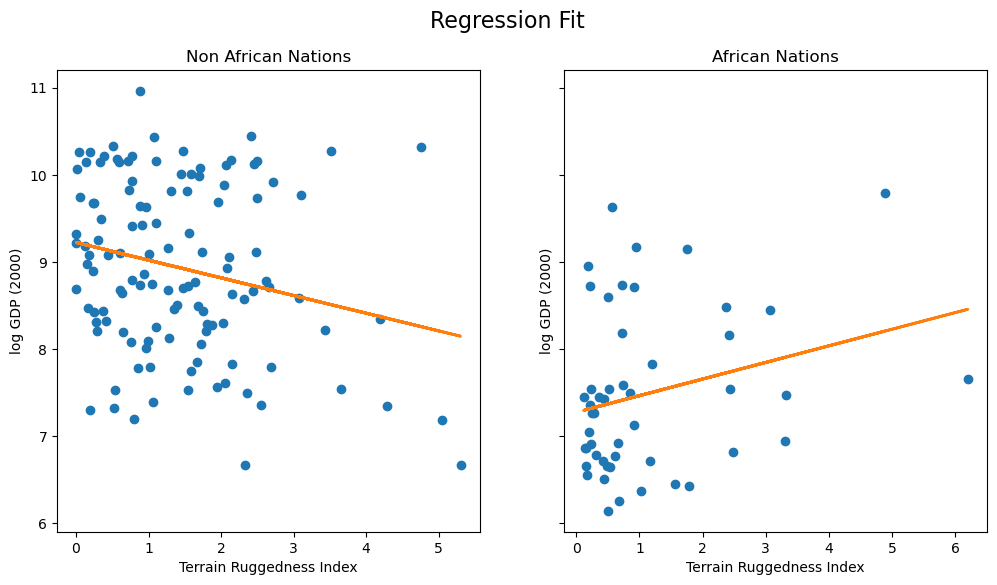

In [20]:
# Plotting the regression fit 

fit = df.copy()
# Add column to the dataset which has the line of best fit
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.pyplot.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")


In [21]:
# Seems like a rugged terrain negatively affects GDP outside Africa, and positively effects GDP in Africa. 
# Can look at how this would vary due to paramter uncertainty - need to use Bayesian modelling 

# Bayesian Regression with pyro's Stochastic Variational Inference (SVI) 

# Need priors for parameters 

from pyro.nn import PyroSample

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        # This is where we now define priors on the parameters
        # Both priors are normals, mean=0, std=1
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 1.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean 

In [22]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [23]:
# Optimizing the Evidence Lower Bound 

from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 ==0: 
        print("[iteration %04d] loss: %.4f" % (j+1, loss/len(data)))

[iteration 0001] loss: 4.8376
[iteration 0101] loss: 3.1119
[iteration 0201] loss: 2.7829
[iteration 0301] loss: 2.3598
[iteration 0401] loss: 1.9414
[iteration 0501] loss: 1.6980
[iteration 0601] loss: 1.6967
[iteration 0701] loss: 1.6835
[iteration 0801] loss: 1.6974
[iteration 0901] loss: 1.6924
[iteration 1001] loss: 1.6863
[iteration 1101] loss: 1.7203
[iteration 1201] loss: 1.6916
[iteration 1301] loss: 1.6864
[iteration 1401] loss: 1.6913


In [24]:
# Can fetch the optimised parameters by fetching from Pyro's parameter store

guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2187, -1.6221, -0.0928,  0.3219,  9.0464])
AutoDiagonalNormal.scale tensor([0.0597, 0.1272, 0.0428, 0.0696, 0.0722])


In [25]:
# Now have uncertainty estimates for the learned parameters 
# Can look at them in a way that is clearer 

guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.9458, 0.9808, 1.0170]),
 'linear.weight': tensor([[[-1.7079, -0.1217,  0.2749]],
 
         [[-1.6221, -0.0928,  0.3219]],
 
         [[-1.5363, -0.0639,  0.3688]]]),
 'linear.bias': tensor([[8.9977],
         [9.0464],
         [9.0952]])}

In [ ]:
# Model evaluation 

